In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
df=sns.load_dataset("flights")

In [4]:
df["yearmonth"]="01-"+df["month"].astype(str)+"-"+df["year"].astype(str)
df["yearmonth"]=pd.to_datetime(df["yearmonth"])
df.set_index("yearmonth",inplace=True)

In [5]:
df

,year,month,passengers
yearmonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121
...,...,...,...
1960-08-01,1960,Aug,606
1960-09-01,1960,Sep,508
1960-10-01,1960,Oct,461


<Axes: xlabel='yearmonth'>

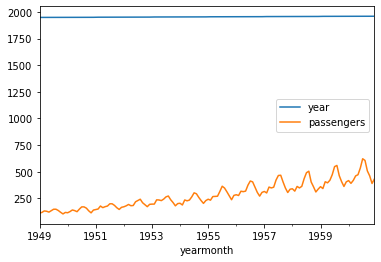

In [6]:
df.plot()

#### Trend and Seasonality components in time-series

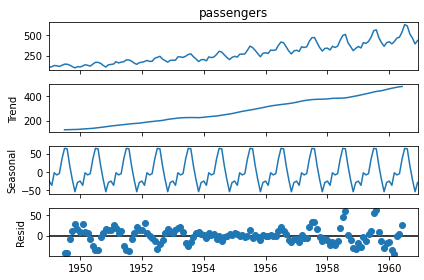

In [7]:
#  Check further for seasonality and trend

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.passengers, period=12)
fig = decomposition.plot()
plt.show()

In [8]:
# Calculate and plot rolling mean and standard deviation for 12 months

df['rollMean'] = df.passengers.rolling(window = 12).mean()
df['rollStd'] = df['passengers'].rolling(window = 12).std()

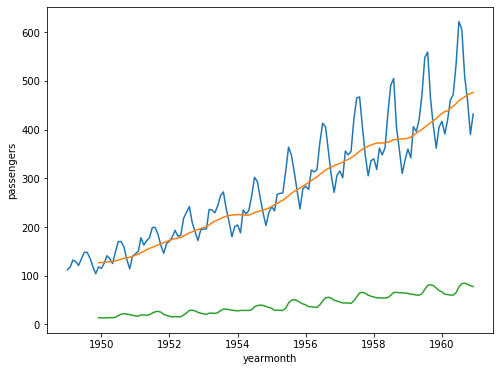

In [9]:
plt.figure(figsize=(8,6))
sns.lineplot(data = df, x = df.index, y = df['passengers'])
sns.lineplot(data = df, x = df.index, y = df['rollMean'])
sns.lineplot(data = df, x = df.index, y = df['rollStd'])
plt.show()
# Conclusion mean is not stationary
# SD is stationary
# So, our data is not stationary

In [10]:
# Now let us perform the ADF test

from statsmodels.tsa.stattools import adfuller

adfTest = adfuller(df['passengers'])
print(adfTest)

stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-vale', '#lags used', 'number of observations used'])
print(stats)

(0.8153688792060463, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
Test Statistic                   0.815369
p-vale                           0.991880
#lags used                      13.000000
number of observations used    130.000000
dtype: float64


In [11]:
# H0: Time series is not stationary
# p-value >= 0.05: Do not reject the null hypothesis
# ADF statistics is less negative (or more positive) than the critical value
# Do not reject the null hypothesis, meaning the series is non-stationary

In [12]:
for key, values in adfTest[4].items():
    print("criticality", key, ":", values)

criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


In [13]:
# We will see that our Test statistic > Critical value in all the cases, so we do not reject the null hypothesis. It means that our data is not stationary.             +

##### Make the data stationary

In [40]:
def test_stationarity(dataFrame, var):
    dataFrame.loc[:,'rollMean'] = dataFrame[var].rolling(window = 12).mean()
    dataFrame.loc[:,'rollStd']  = dataFrame[var].rolling(window = 12).mean()
    
    from statsmodels.tsa.stattools import adfuller

    adfTest = adfuller(dataFrame[var])
    print(adfTest)

    stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-vale', '#lags used', 'number of observations used'])
    print(stats)
    
    for key, values in adfTest[4].items():
        print("criticality", key, ":", values)
    
    plt.figure(figsize=(8,6))
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = var)
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = 'rollMean')
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = 'rollStd')
    plt.show()

In [15]:
# Just get the passengers column into a new dataframe for easier testing
air_df = df[['passengers']].copy() # Double bracets because it is a list within a list
air_df.head()

,passengers
yearmonth,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [16]:
# Create a new column which will contain the shifted value from passengers column
air_df['shift'] = air_df['passengers'].shift(1)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']
air_df.head()

,passengers,shift,shiftDiff
yearmonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,6.0
1949-03-01,132,118.0,14.0
1949-04-01,129,132.0,-3.0
1949-05-01,121,129.0,-8.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


(-2.8292668241699923, 0.054213290283826474, 12, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.5069317854084)
Test Statistic                  -2.829267
p-vale                           0.054213
#lags used                      12.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


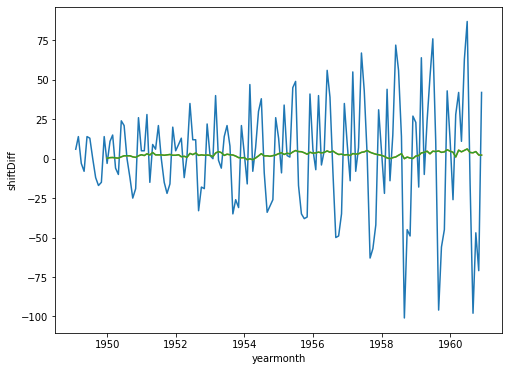

In [17]:
# Test stationarity
test_stationarity(air_df.dropna(), 'shiftDiff')
# p-value is just close to 0.05, so let us try a shift of 2

In [18]:
# Shift of 2
air_df['shift'] = air_df['passengers'].shift(2)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']
air_df.head()

,passengers,shift,shiftDiff
yearmonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,112.0,20.0
1949-04-01,129,118.0,11.0
1949-05-01,121,132.0,-11.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


(-2.961695135555423, 0.038629757676988535, 11, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 985.7309222414162)
Test Statistic                  -2.961695
p-vale                           0.038630
#lags used                      11.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


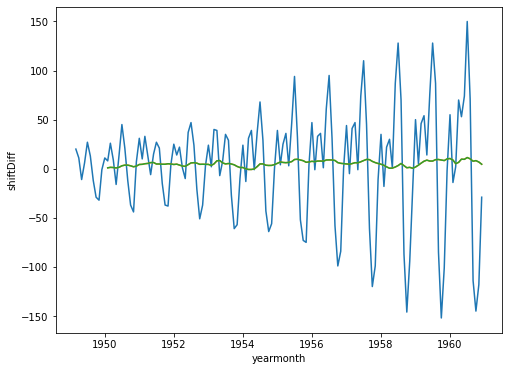

In [19]:
# Test stationarity
test_stationarity(air_df.dropna(), 'shiftDiff')
# p-value = 0.03, which is < 0.05, so, 
# Conclusion: the data has become somewhat staionary

##### ARIMA

In [20]:
airP = df[['passengers']].copy(deep=True)

airP['firstDiff'] = airP['passengers'].diff()
airP['Diff12'] = airP['passengers'].diff(12) #This will be later used in SARIMAX

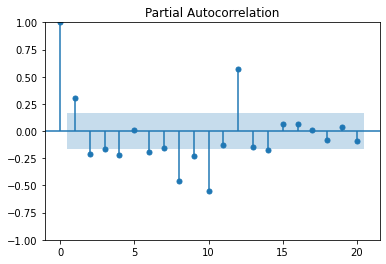

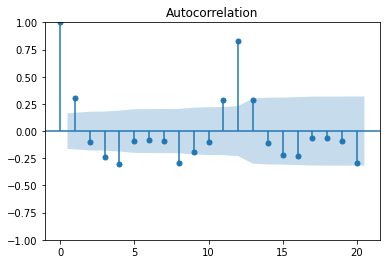

In [21]:
# Arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(airP['firstDiff'].dropna(), lags=20)
plt.show()

plot_acf(airP['firstDiff'].dropna(), lags=20)
plt.show()

In [22]:
# Build ARIMA model

train = airP[:round(len(airP)*70/100)] # Take the first 70% data
print(train.tail()) # Just to checck where it ends

            passengers  firstDiff  Diff12
yearmonth                                
1957-01-01         315        9.0    31.0
1957-02-01         301      -14.0    24.0
1957-03-01         356       55.0    39.0
1957-04-01         348       -8.0    35.0
1957-05-01         355        7.0    37.0


In [23]:
test = airP[round(len(airP)*70/100) : ] # Take the last 30% data, starting from 71%
print(test.head()) # Just to checck where it starts

            passengers  firstDiff  Diff12
yearmonth                                
1957-06-01         422       67.0    48.0
1957-07-01         465       43.0    52.0
1957-08-01         467        2.0    62.0
1957-09-01         404      -63.0    49.0
1957-10-01         347      -57.0    41.0


In [24]:
model = ARIMA(train['passengers'], order=(1,2,1)) # Parameters: p,d,q
model_fit = model.fit()
prediction = model_fit.predict(start = test.index[0], end=test.index[-1])
airP['arimaPred'] = prediction
print(airP.tail())

            passengers  firstDiff  Diff12   arimaPred
yearmonth                                            
1960-08-01         606      -16.0    47.0  451.950232
1960-09-01         508      -98.0    45.0  454.403560
1960-10-01         461      -47.0    54.0  456.856887
1960-11-01         390      -71.0    28.0  459.310215
1960-12-01         432       42.0    27.0  461.763543


C:\Users\dai.STUDENTSDC\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dai.STUDENTSDC\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dai.STUDENTSDC\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


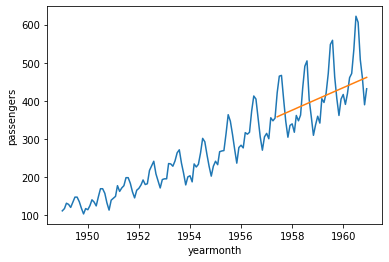

In [27]:
# Plot
sns.lineplot(data=airP, x= airP.index, y='passengers')
sns.lineplot(data=airP, x= airP.index, y='arimaPred')
plt.show()

##### SARIMAX

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
model=SARIMAX(train["passengers"],order=(1,2,1),seasonal_order=(1,2,1,12))
model_fit=model.fit()
prediction=model_fit.predict(start=test.index[0],end=test.index[-1])
airP["sarimaxPred"]=prediction
airP.tail()

C:\Users\dai.STUDENTSDC\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dai.STUDENTSDC\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,passengers,firstDiff,Diff12,arimaPred,sarimaxPred
yearmonth,,,,,
1960-08-01,606,-16.0,47.0,451.950232,588.744169
1960-09-01,508,-98.0,45.0,454.403560,518.356813
1960-10-01,461,-47.0,54.0,456.856887,452.581066
1960-11-01,390,-71.0,28.0,459.310215,402.801504
1960-12-01,432,42.0,27.0,461.763543,450.778813


<Axes: xlabel='yearmonth', ylabel='passengers'>

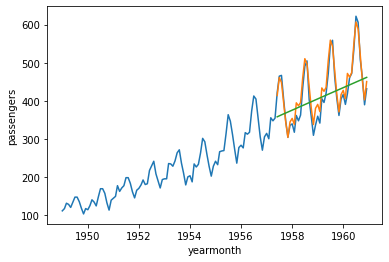

In [31]:
#Plot
airP.dropna()
airP.head()
sns.lineplot(data=airP,x=airP.index,y="passengers")
sns.lineplot(data=airP,x=airP.index,y="sarimaxPred")
sns.lineplot(data=airP,x=airP.index,y="arimaPred")

In [32]:
#FuturePrediction First check the last date in our dataset
airP.tail()

,passengers,firstDiff,Diff12,arimaPred,sarimaxPred
yearmonth,,,,,
1960-08-01,606,-16.0,47.0,451.950232,588.744169
1960-09-01,508,-98.0,45.0,454.403560,518.356813
1960-10-01,461,-47.0,54.0,456.856887,452.581066
1960-11-01,390,-71.0,28.0,459.310215,402.801504
1960-12-01,432,42.0,27.0,461.763543,450.778813


In [33]:
#MS month start frequency
#Create  a data frame to hold index values from 01.01.61 to 01.12.62
futureDate=pd.DataFrame(pd.date_range(start="1961-01-01",end="1962-12-01",freq="MS"),columns=["Dates"])
futureDate.set_index("Dates",inplace=True)
futureDate.head()

""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


In [34]:
#Predict and print
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1])

1961-01-01    462.543788
1961-02-01    437.534721
1961-03-01    508.333310
1961-04-01    497.711730
1961-05-01    511.014645
1961-06-01    591.655392
1961-07-01    652.312223
1961-08-01    632.005956
1961-09-01    555.825821
1961-10-01    485.325618
1961-11-01    431.972481
1961-12-01    482.535374
1962-01-01    494.936295
1962-02-01    466.777166
1962-03-01    541.926866
1962-04-01    530.299268
1962-05-01    545.024198
1962-06-01    630.708702
1962-07-01    694.817122
1962-08-01    672.368024
1962-09-01    590.295369
1962-10-01    514.981255
1962-11-01    458.005623
1962-12-01    511.056670
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: xlabel='yearmonth', ylabel='passengers'>

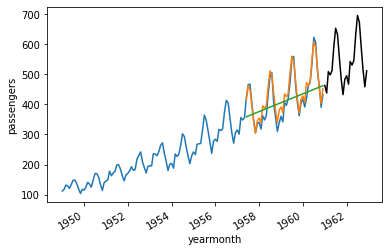

In [39]:
#Plot
airP.dropna()
sns.lineplot(data=airP,x=airP.index,y="passengers")
sns.lineplot(data=airP,x=airP.index,y="sarimaxPred")
sns.lineplot(data=airP,x=airP.index,y="arimaPred")
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1]).plot(c="k")